In [1]:
from zgulde.ds_imports import *
import acquire

canada, mexico = acquire.get_data()
canada

,port_name,state,port_code,border,date,crossing_method,n_crossings
0,Alexandria Bay,NY,708,US-Canada Border,2019-12-01,Bus Passengers,740
1,Baudette,MN,3424,US-Canada Border,2019-12-01,Bus Passengers,83
2,Blaine,WA,3004,US-Canada Border,2019-12-01,Bus Passengers,17029
4,Buffalo-Niagara Falls,NY,901,US-Canada Border,2019-12-01,Bus Passengers,9910
5,Calais,ME,115,US-Canada Border,2019-12-01,Bus Passengers,279
...,...,...,...,...,...,...,...
353956,Point Roberts,WA,3017,US-Canada Border,1996-01-01,Rail Containers Empty,0
353957,Antler,ND,3413,US-Canada Border,1996-01-01,Personal Vehicle Passengers,1576
353959,Calais,ME,115,US-Canada Border,1996-01-01,Trucks,8955
353960,Carbury,ND,3421,US-Canada Border,1996-01-01,Truck Containers Empty,0


## Visualize Location By Port By Method

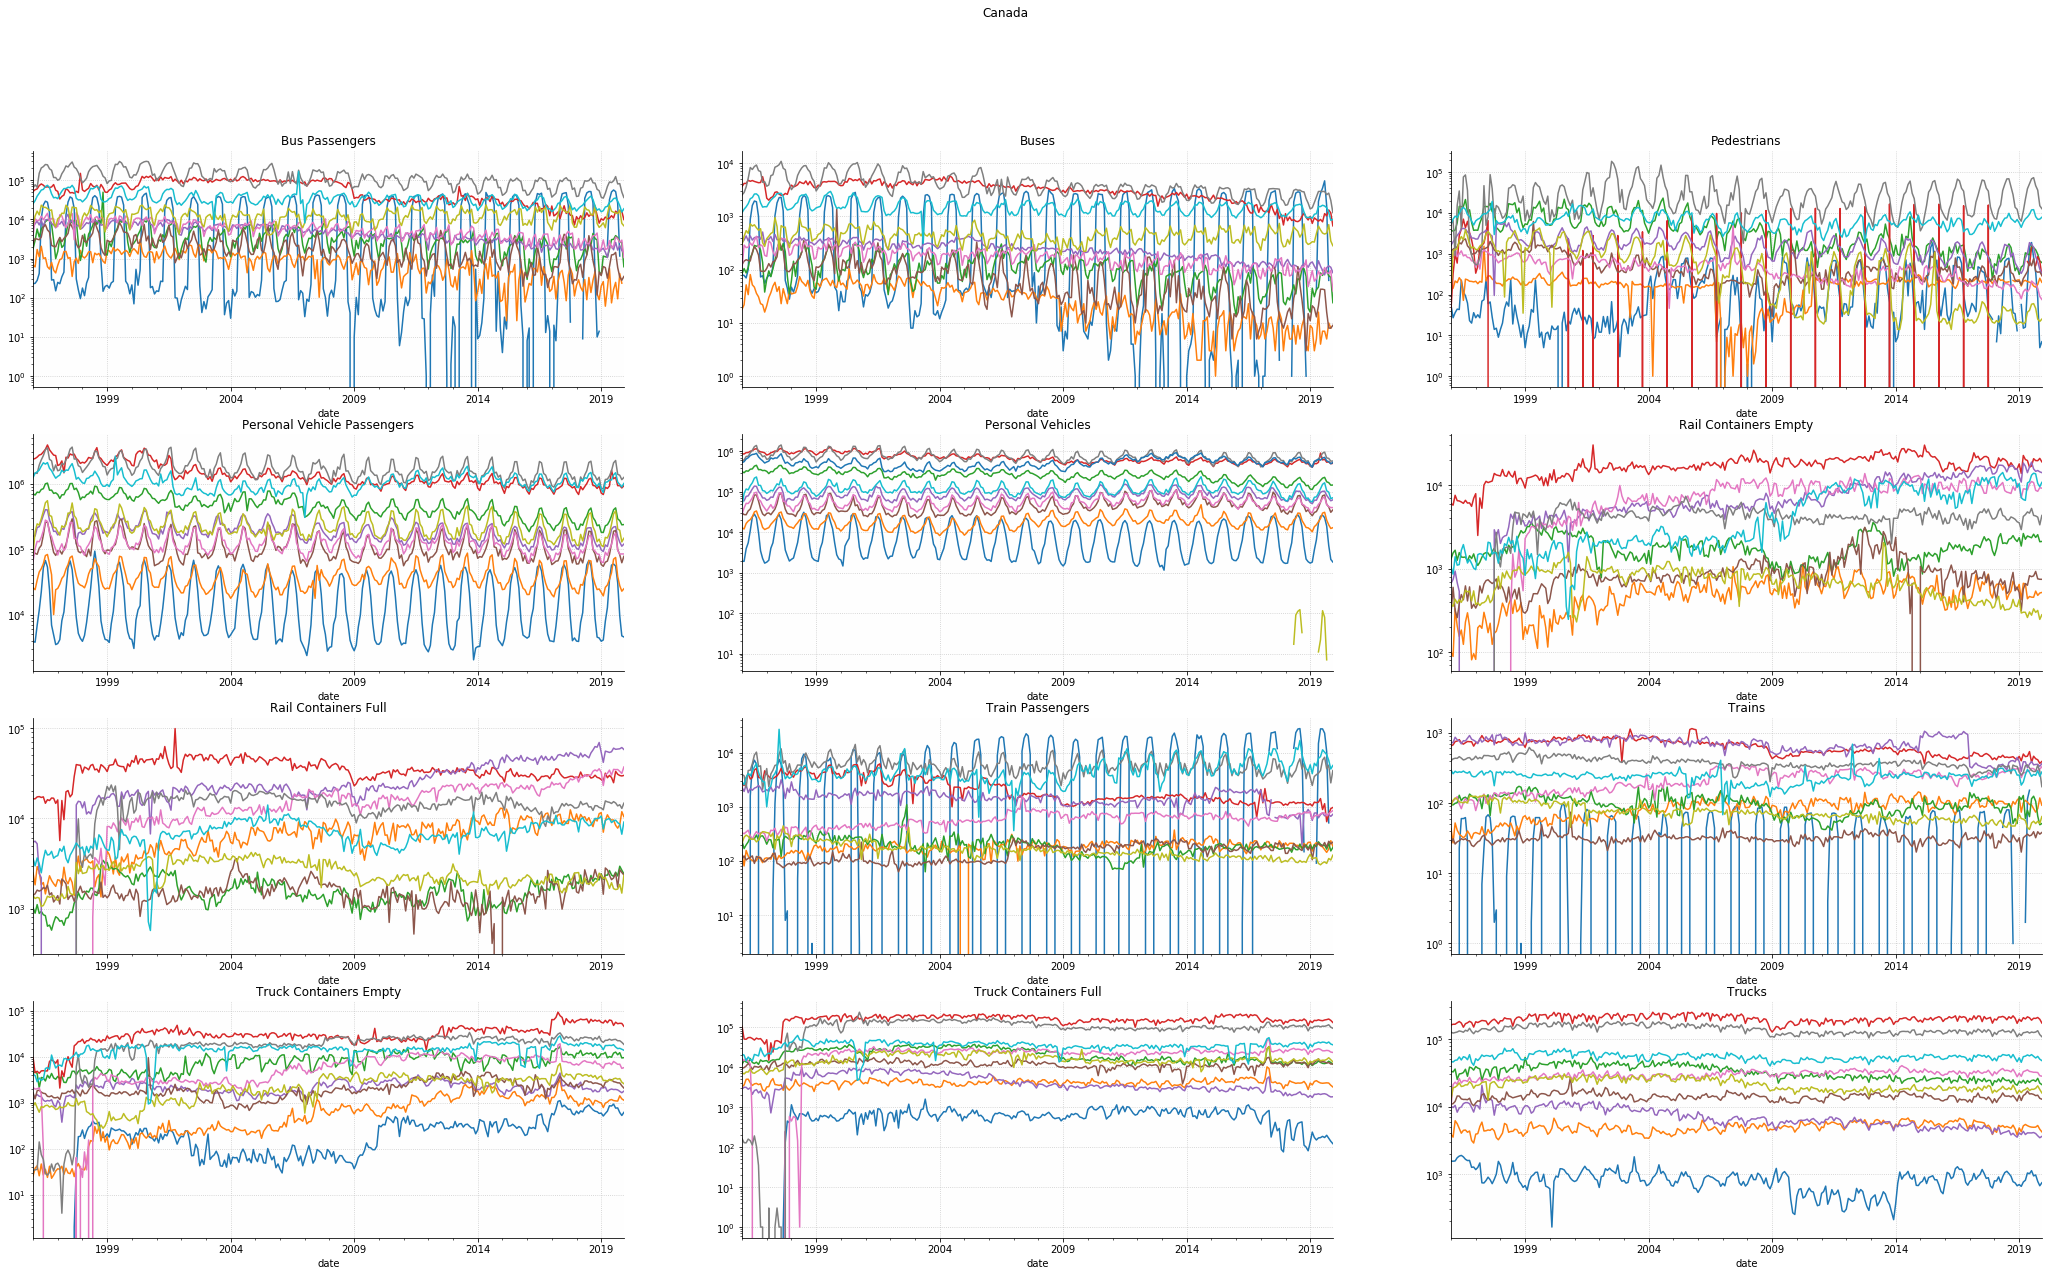

In [2]:
fig, axs = plt.subplots(4, 3, figsize=(36, 20))

fig.suptitle('Canada')

for ax, (method, data) in zip(axs.ravel(), canada.groupby('crossing_method')):
    data.pivot_table('n_crossings', 'date', 'state', aggfunc='sum').plot(ax=ax)
    ax.set(title=method)
    ax.get_legend().remove()
    ax.set_yscale('log')

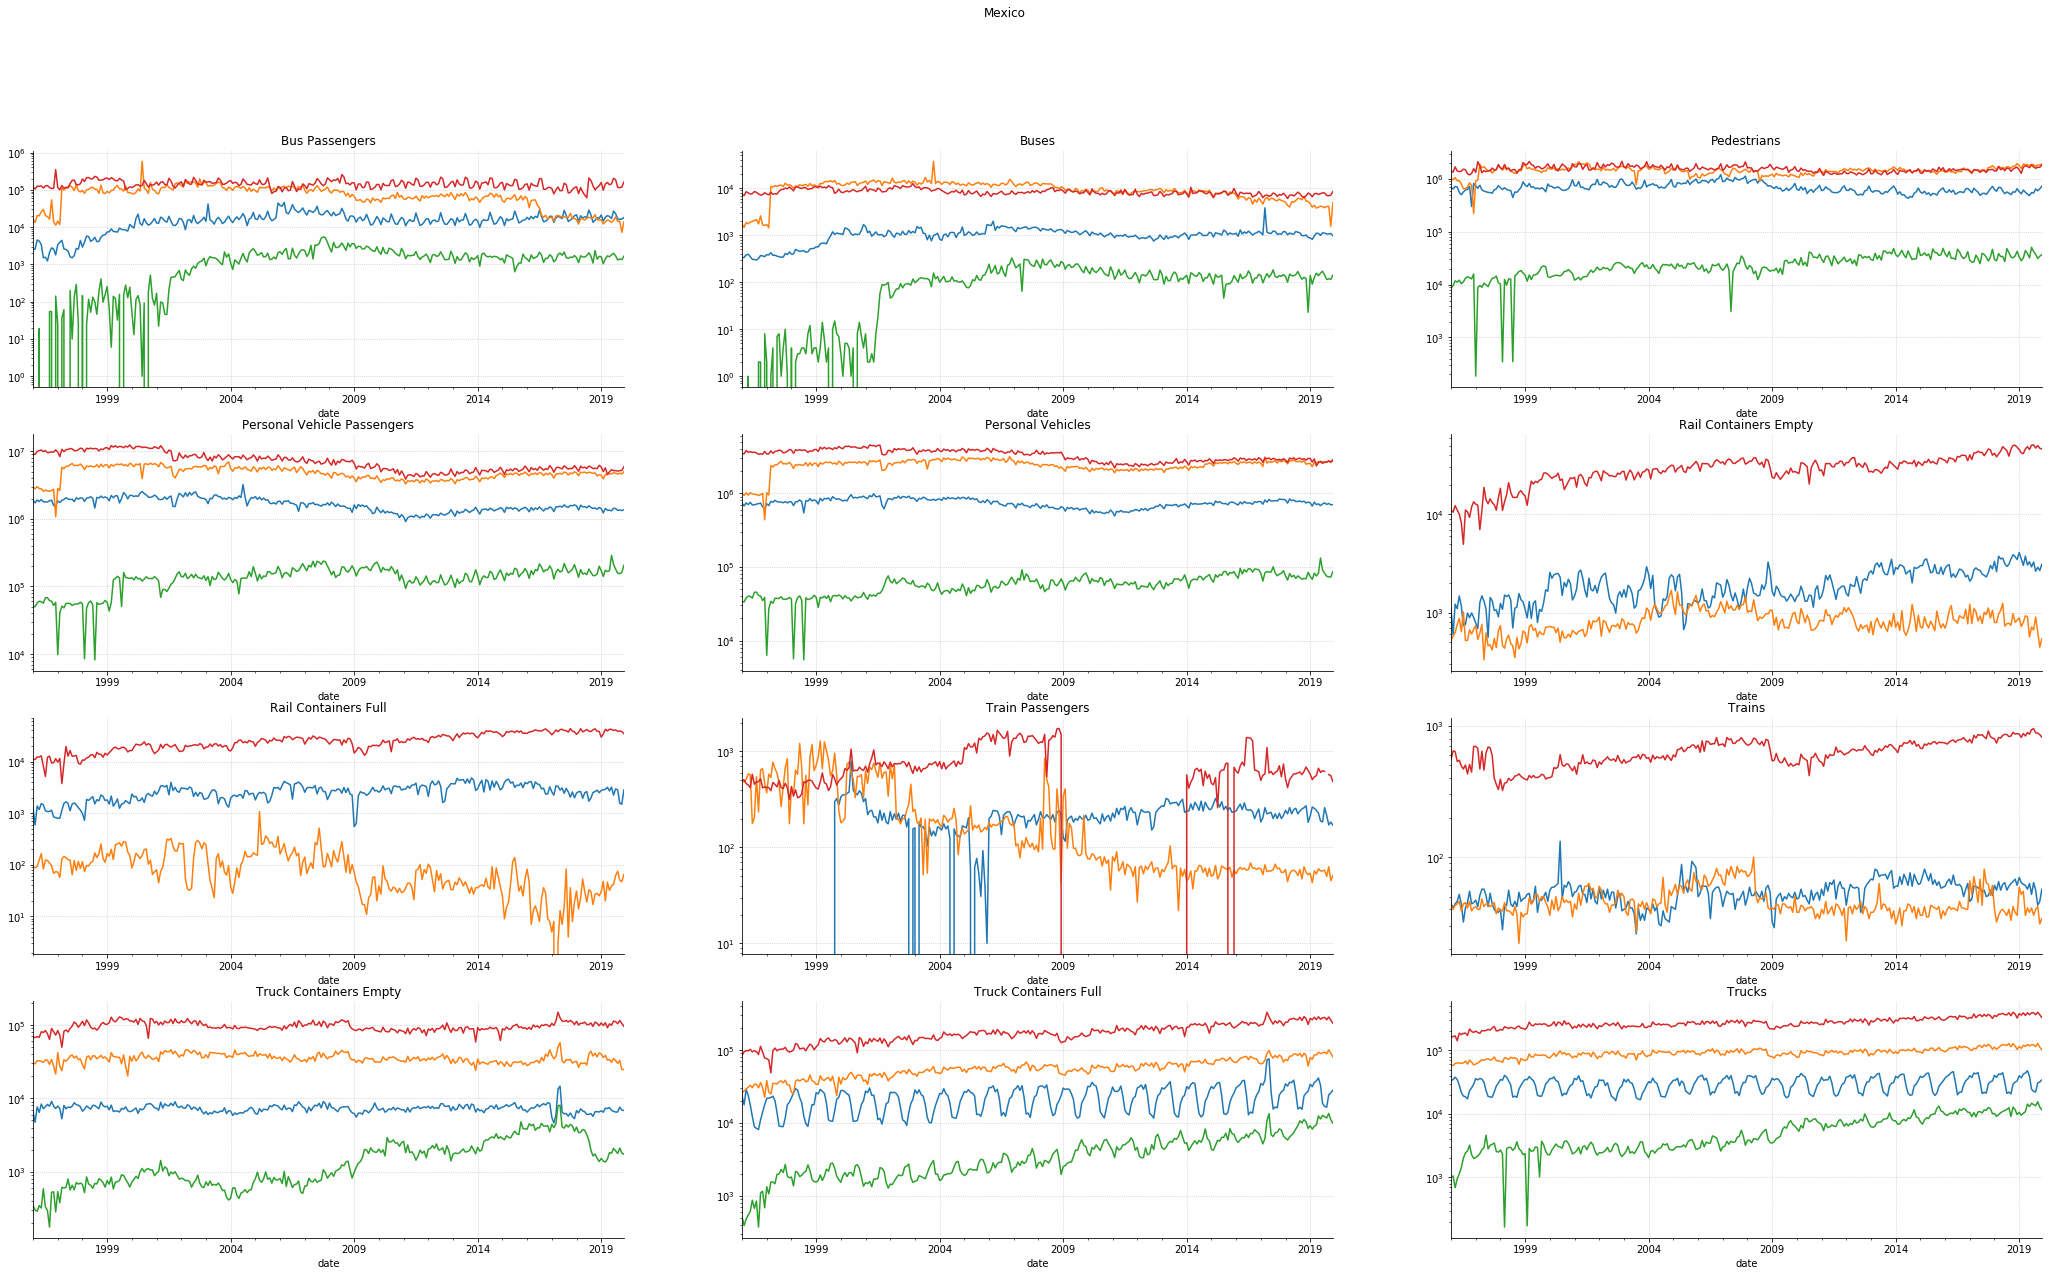

In [3]:
fig, axs = plt.subplots(4, 3, figsize=(36, 20))

fig.suptitle('Mexico')

for ax, (method, data) in zip(axs.ravel(), mexico.groupby('crossing_method')):
    data.pivot_table('n_crossings', 'date', 'state', aggfunc='sum').plot(ax=ax)
    ax.set(title=method)
    ax.get_legend().remove()
    ax.set_yscale('log')

## Cluster Ports

In [4]:
from sklearn.cluster import KMeans

1. Get the data into the shape we want
1. Standardize the data
1. Kmeans
1. Add the clusters back to the original dataset

In [61]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale_col(col: pd.Series) -> pd.Series:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(col.values.reshape(-1, 1))
    return pd.Series(scaled[:, 0], index=col.index)

ca_ports = (canada
 .set_index('date')
 .sort_index()
 ['2015':'2018']
 .pivot_table(values='n_crossings', index='port_name', columns='crossing_method', aggfunc='median')
 .fillna(0)
 .apply(min_max_scale_col))

mex_ports = (mexico
 .set_index('date')
 .sort_index()
 ['2015':'2018']
 .pivot_table(values='n_crossings', index='port_name', columns='crossing_method', aggfunc='median')
 .fillna(0)
 .apply(min_max_scale_col))

Text(0, 0.5, 'Inertia')

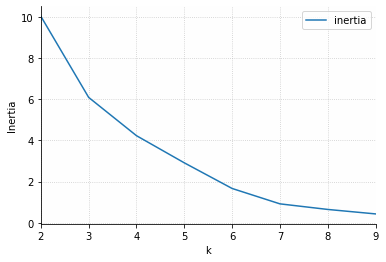

In [73]:
from sklearn.cluster import KMeans

data = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(mex_ports)
    data.append({'k': k, 'inertia': kmeans.inertia_})
    
pd.DataFrame(data).set_index('k').plot()
plt.ylabel('Inertia') # inertia is the sum of the squared distances from each point to its cluster center

In [99]:
kmeans = KMeans(n_clusters=2, random_state=123).fit(mex_ports)
mex_clusters = pd.Series(kmeans.predict(mex_ports), index=mex_ports.index, name='port_cluster')
mex_clusters

port_name
Andrade                0
Boquillas              0
Brownsville            0
Calexico               0
Calexico East          0
Columbus               0
Cross Border Xpress    0
Del Rio                0
Douglas                0
Eagle Pass             0
El Paso                1
Hidalgo                0
Laredo                 1
Lukeville              0
Naco                   0
Nogales                0
Otay Mesa              1
Presidio               0
Progreso               0
Rio Grande City        0
Roma                   0
San Luis               0
San Ysidro             1
Santa Teresa           0
Sasabe                 0
Tecate                 0
Tornillo-Fabens        0
Name: port_cluster, dtype: int32

In [102]:
mexico

,port_name,state,port_code,border,date,crossing_method,n_crossings
3,Brownsville,TX,2301,US-Mexico Border,2019-12-01,Bus Passengers,4668
6,Calexico East,CA,2507,US-Mexico Border,2019-12-01,Bus Passengers,4080
8,Columbus,NM,2406,US-Mexico Border,2019-12-01,Bus Passengers,1452
11,Douglas,AZ,2601,US-Mexico Border,2019-12-01,Bus Passengers,107
13,Eagle Pass,TX,2303,US-Mexico Border,2019-12-01,Bus Passengers,8525
...,...,...,...,...,...,...,...
353936,Douglas,AZ,2601,US-Mexico Border,1996-01-01,Trains,0
353937,San Ysidro,CA,2504,US-Mexico Border,1996-01-01,Rail Containers Full,0
353938,Santa Teresa,NM,2408,US-Mexico Border,1996-01-01,Personal Vehicles,4719
353945,Presidio,TX,2403,US-Mexico Border,1996-01-01,Pedestrians,645


In [103]:
mexico = mexico.set_index('port_name').join(mex_clusters).reset_index()

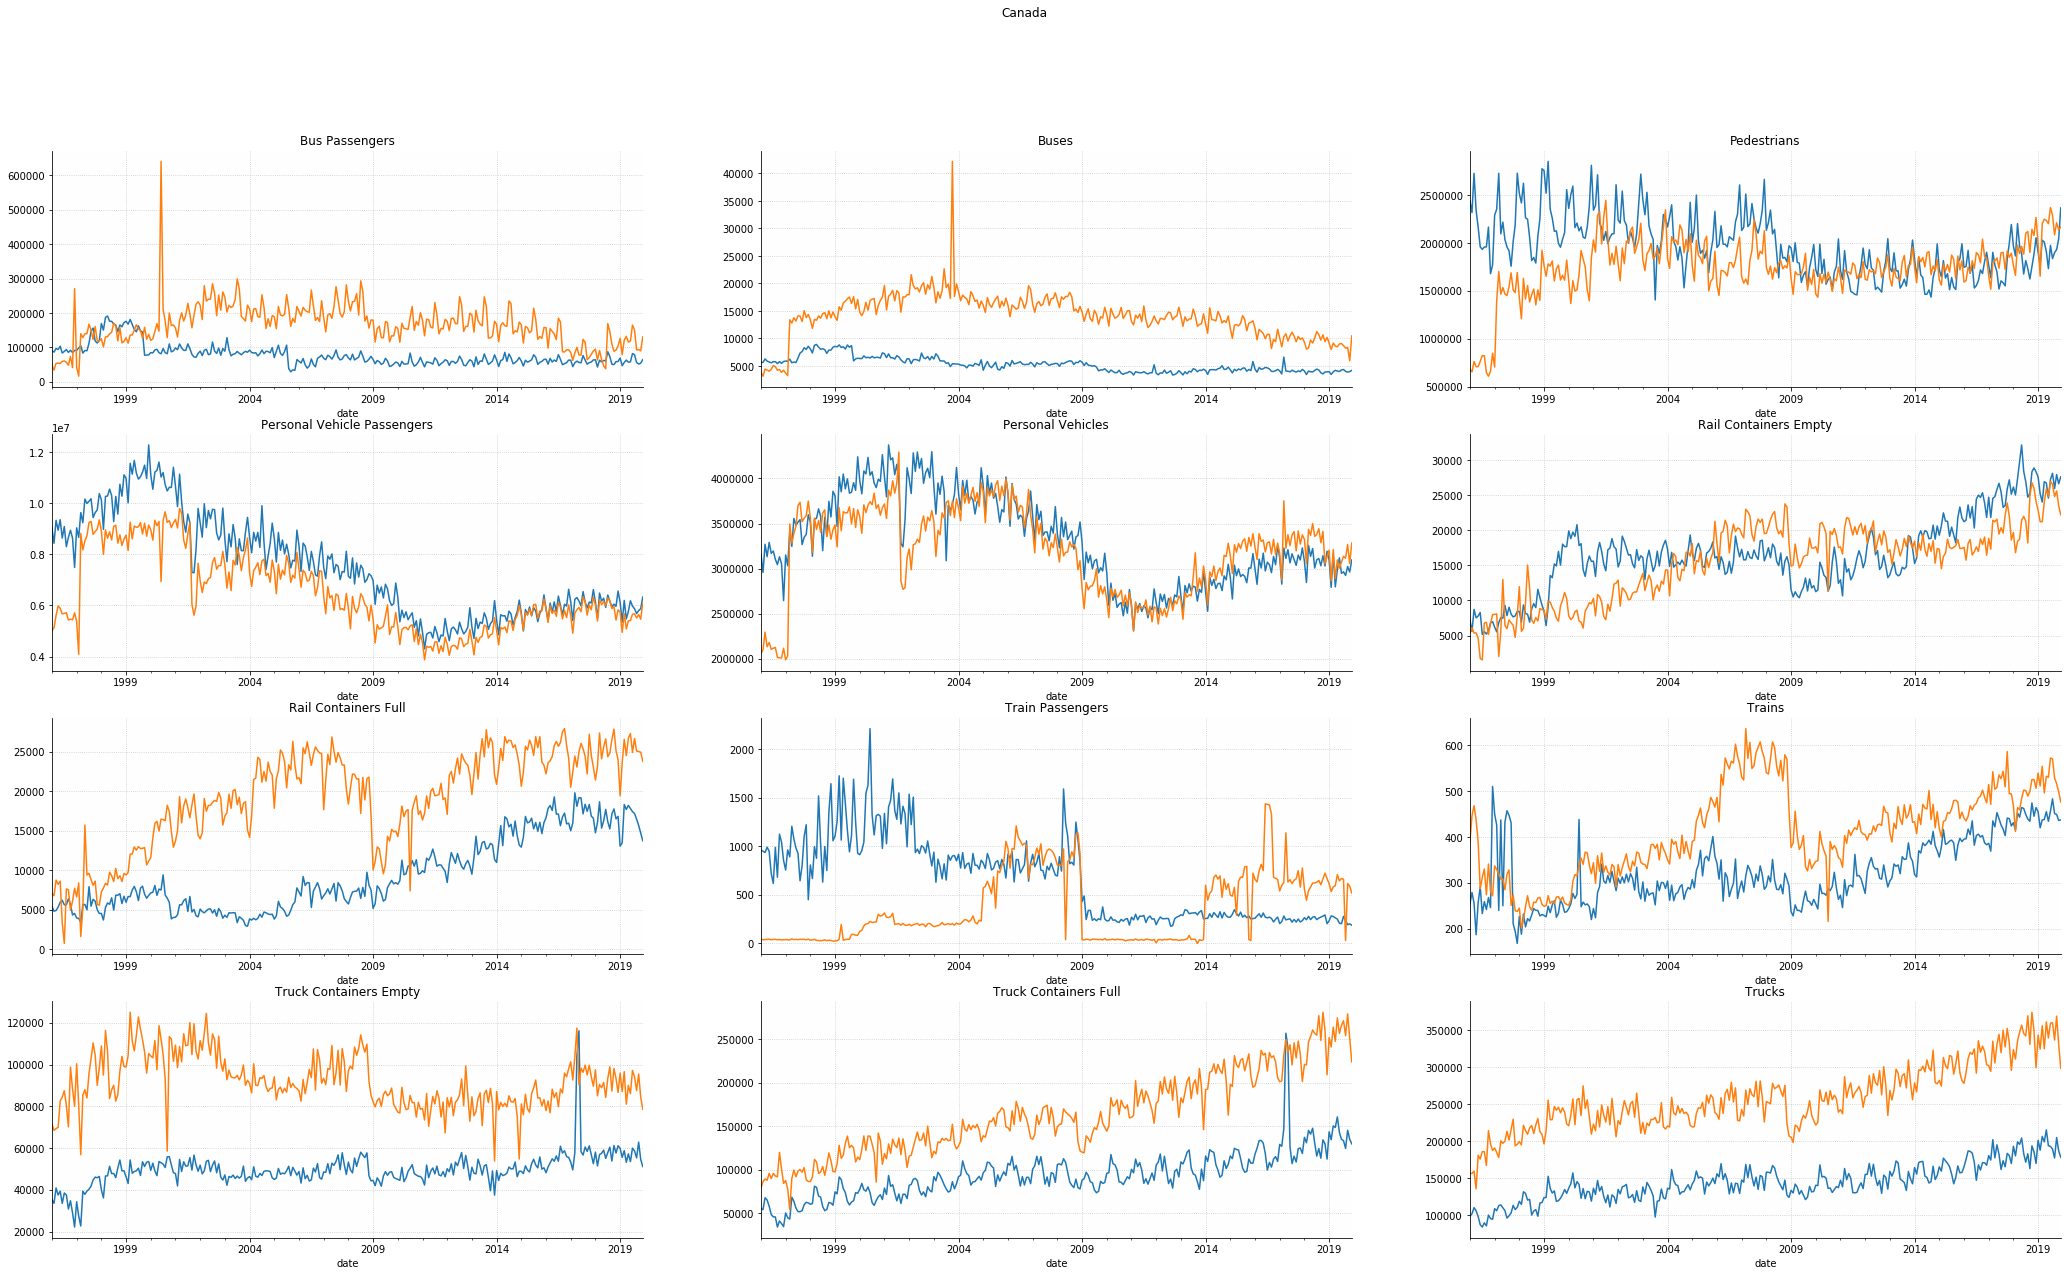

In [107]:
fig, axs = plt.subplots(4, 3, figsize=(36, 20))

fig.suptitle('Canada')

for ax, (method, data) in zip(axs.ravel(), mexico.groupby('crossing_method')):
    data.pivot_table('n_crossings', 'date', 'port_cluster', aggfunc='sum').plot(ax=ax)
    ax.set(title=method)
    ax.get_legend().remove()
#     ax.set_yscale('log')